# Setup

In [1]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import os

from datetime import datetime
from copy import deepcopy
from torch import nn
from torchvision import transforms
from tqdm import tqdm

from cifar10_utils import get_cifar10, get_dataloader
from models import Bottleneck, ResNet, CBAM, BAM, SEBlock, eca_layer

%pip install grad-cam --quiet
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Seed for reproduceability
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
def save_model_and_data(name, model, test_accuracy, test_loss, logging_dict):
    os.mkdir(f'./models/{name}')
    torch.save(model, f'./models/{name}/{name}.pt')
    data = {'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'logging_dict': logging_dict,
            'datetime': datetime.now()}
    with open(f'./models/{name}/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [4]:
def make_plots(logging_dict, model_name, avg_train=True):
#     logging_dict = {'loss': {'train': [], 'validation': []},
#                 'accuracy': {'train': [], 'validation': []},
#                 'lr': [],
#                 'batches_per_epoch': [],}
    epoch_ends = np.cumsum(logging_dict['batches_per_epoch'])
    
    def get_avg_per_epoch(batch_data):
        result = [None,]
        for i in range(len(epoch_ends) - 1):
            result.append(np.average(batch_data[epoch_ends[i]:epoch_ends[i + 1]]))
        return result
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    metrics = ('loss', 'accuracy')
    for metric, ax in zip(metrics, axes.ravel()):
#         ax.plot(logging_dict[metric]['train'])
        if avg_train:
            ax.plot(get_avg_per_epoch(logging_dict[metric]['train']), '.-', label='training set')
            ax.plot(logging_dict[metric]['validation'], '.-', label='validation set')
            ax.set(title=metric, xlabel='epoch', xticks=np.arange(len(epoch_ends)))
        else:
            ax.plot(logging_dict[metric]['train'],'.-', label='training set')
            ax.plot(epoch_ends, logging_dict[metric]['validation'],'.-', label='validation set')
            ax.set(title=metric, xlabel='batch')
    
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

## Backbone Architecture

We will use ResNet50 as our backbone architecture.

In [5]:
# Loading the dataset
cifar10 = get_cifar10()
cifar10_loader = get_dataloader(cifar10, batch_size=128,return_numpy=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def evaluate_model(model, data_loader):
    """
    Performs the evaluation of the MLP model on a given dataset.

    Args:
      model: An instance of 'MLP', the model to evaluate.
      data_loader: The data loader of the dataset to evaluate.
    Returns:
        accuracy
    """
    accuracies_per_batch, losses_per_batch = [], []
    loss_module = nn.CrossEntropyLoss()
    # Get accuracy for epoch
    for batch in data_loader:
        
        # Get validation images and labels
        X = batch[0].to(device)
        y = batch[1].to(device)
        
        # Get predictions on validation set
        model.eval()
        with torch.no_grad():
            pred_logits = model.forward(X)
            pred_classes = torch.argmax(torch.softmax(pred_logits, dim=1), axis=1)
        
        # Calculate accuracy := # of correct preds / total # of preds
        current_accuracy = torch.sum(pred_classes == y) / pred_classes.shape[0]
        accuracies_per_batch.append(current_accuracy.item())
        current_loss = loss_module(pred_logits, y).item()
        losses_per_batch.append(current_loss)

    accuracy = np.average(accuracies_per_batch)
    loss = np.average(losses_per_batch)

    return accuracy, loss

In [7]:
def train(model, epochs=15, lr=0.01, momentum=0, verbose=True):
    
    logging_dict = {'loss': {'train': [], 'validation': []},
                    'accuracy': {'train': [], 'validation': []},
                    'lr': [],
                    'batches_per_epoch': [],
                    'momentum': momentum}
    
    for epoch in tqdm(range(epochs)):
        
        batches_per_epoch = 0
        
        model.train()
        
        # Loss module and optimizer
        loss_module = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        
         
        for batch in cifar10_loader['train']:
                        
            batches_per_epoch += 1
            
            # Get training images and labels
            X_train = batch[0].to(device)
            y_train = batch[1].to(device)
            
            # Forward pass
            train_pred_logits = model.forward(X_train)
            
            # Calculate loss
            loss = loss_module(train_pred_logits, y_train)
            logging_dict['loss']['train'].append(loss.item())
            
            # Calculate accuracy
            train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), axis=1)
            train_accuracy = torch.sum(train_pred_class == y_train) / train_pred_class.shape[0]
            logging_dict['accuracy']['train'].append(train_accuracy.item())
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()

        
        # Log num of batches for this epoch
        logging_dict['batches_per_epoch'].append(batches_per_epoch)
        
        # Log current LR
        logging_dict['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Update LR
        scheduler.step(loss)
        
        # Get metrics on validation set
        validation_accuracy, validation_loss = evaluate_model(model, cifar10_loader['validation'])
        logging_dict['accuracy']['validation'].append(validation_accuracy.item())
        logging_dict['loss']['validation'].append(validation_loss.item())
        
        # Determine if best model
        if len(logging_dict['accuracy']['validation']) == 1 or \
            all([validation_accuracy > acc for acc in logging_dict['accuracy']['validation']]):
            best_model = deepcopy(model)
   
        if verbose:
            print(f'\n{epoch = }, '
                  f'training accuracy: {train_accuracy.item():.3f}, '
                  f'training loss: {loss.item():.3f}',
                  f'validation accuracy: {validation_accuracy.item():.3f}, '
                  f'validation loss: {validation_loss.item():.3f}',
                 )
    
    # Get metrics on test set
    test_accuracy, test_loss = evaluate_model(best_model, cifar10_loader['test'])
    
    return best_model, test_accuracy, test_loss, logging_dict

# Base Models comparison

In [8]:
# resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 10).to(device)
# resnet_best_model, resnet_test_acc, resnet_test_loss, resnet_logging_dict = train(resnet50)
# # %rm -r './models/resnet'
# save_model_and_data('resnet', resnet_best_model, resnet_test_acc, resnet_test_loss, resnet_logging_dict)
# make_plots(resnet_logging_dict, 'ResNet', avg_train=True)

In [9]:
# layers = [3, 4, 6, 3]
# resnet50_eca = ResNet(Bottleneck,
#                        layers,
#                        10,
#                        extra_modules_list=[[eca_layer(layer * 4 , 3).to(device)] for layer in layers],
#                        before_downsampling_list=[[True] for layer in layers]).to(device)
# eca_best_model, eca_test_acc, eca_test_loss, eca_logging_dict = train(resnet50_eca)
# %rm -r './models/eca'
# save_model_and_data('eca', eca_best_model, eca_test_acc, eca_test_loss, eca_logging_dict)
# make_plots(eca_logging_dict, 'ECA', avg_train=True)

In [10]:
# layers = [3, 4, 6, 3]
# resnet50_cbam = ResNet(Bottleneck,
#                        layers,
#                        10,
#                        extra_modules_list=[[CBAM(64 * 4).to(device)], [CBAM(128 * 4).to(device)], [CBAM(256 * 4).to(device)], [CBAM(512 * 4).to(device)]],
#                        before_downsampling_list=[[False] for layer in layers]).to(device)
# cbam_best_model, cbam_test_acc, cbam_test_loss, cbam_logging_dict = train(resnet50_cbam)
# %rm -r './models/cbam'
# save_model_and_data('cbam', cbam_best_model, cbam_test_acc, cbam_test_loss, cbam_logging_dict)
# make_plots(cbam_logging_dict, 'CBAM', avg_train=True)

In [11]:
# layers = [3, 4, 6, 3]
# resnet50_bam = ResNet(Bottleneck,
#                        layers,
#                        10,
#                        extra_modules_per_layer_list=[[BAM(64 * 4).to(device)], [BAM(128 * 4).to(device)], [BAM(256 * 4).to(device)], None]).to(device)
# bam_best_model, bam_test_acc, bam_test_loss, bam_logging_dict = train(resnet50_bam)
# %rm -r './models/bam'
# save_model_and_data('bam', bam_best_model, bam_test_acc, bam_test_loss, bam_logging_dict)
# make_plots(bam_logging_dict, 'BAM', avg_train=True)

  7%|▋         | 1/15 [00:49<11:26, 49.06s/it]


epoch = 0, training accuracy: 0.344, training loss: 1.897 validation accuracy: 0.292, validation loss: 1.909


 13%|█▎        | 2/15 [01:37<10:32, 48.67s/it]


epoch = 1, training accuracy: 0.422, training loss: 1.614 validation accuracy: 0.378, validation loss: 1.698


 20%|██        | 3/15 [02:25<09:42, 48.50s/it]


epoch = 2, training accuracy: 0.383, training loss: 1.615 validation accuracy: 0.405, validation loss: 1.613


 27%|██▋       | 4/15 [03:13<08:52, 48.39s/it]


epoch = 3, training accuracy: 0.430, training loss: 1.499 validation accuracy: 0.425, validation loss: 1.554


 33%|███▎      | 5/15 [04:02<08:03, 48.35s/it]


epoch = 4, training accuracy: 0.430, training loss: 1.485 validation accuracy: 0.465, validation loss: 1.464


 40%|████      | 6/15 [04:50<07:15, 48.42s/it]


epoch = 5, training accuracy: 0.492, training loss: 1.323 validation accuracy: 0.490, validation loss: 1.394


 47%|████▋     | 7/15 [05:39<06:26, 48.35s/it]


epoch = 6, training accuracy: 0.562, training loss: 1.183 validation accuracy: 0.490, validation loss: 1.403


 53%|█████▎    | 8/15 [06:27<05:38, 48.40s/it]


epoch = 7, training accuracy: 0.516, training loss: 1.303 validation accuracy: 0.520, validation loss: 1.348


 60%|██████    | 9/15 [07:15<04:50, 48.35s/it]


epoch = 8, training accuracy: 0.594, training loss: 1.073 validation accuracy: 0.515, validation loss: 1.366


 67%|██████▋   | 10/15 [08:04<04:01, 48.32s/it]


epoch = 9, training accuracy: 0.641, training loss: 0.913 validation accuracy: 0.528, validation loss: 1.362


 73%|███████▎  | 11/15 [08:52<03:13, 48.31s/it]


epoch = 10, training accuracy: 0.656, training loss: 1.023 validation accuracy: 0.525, validation loss: 1.398


 80%|████████  | 12/15 [09:40<02:24, 48.27s/it]


epoch = 11, training accuracy: 0.805, training loss: 0.594 validation accuracy: 0.538, validation loss: 1.420


 87%|████████▋ | 13/15 [10:28<01:36, 48.23s/it]


epoch = 12, training accuracy: 0.852, training loss: 0.510 validation accuracy: 0.538, validation loss: 1.486


 93%|█████████▎| 14/15 [11:16<00:48, 48.21s/it]


epoch = 13, training accuracy: 0.812, training loss: 0.511 validation accuracy: 0.531, validation loss: 1.658


100%|██████████| 15/15 [12:04<00:00, 48.33s/it]


epoch = 14, training accuracy: 0.875, training loss: 0.342 validation accuracy: 0.541, validation loss: 1.699


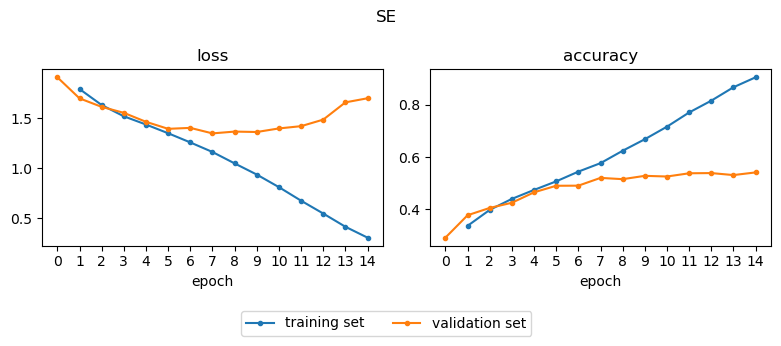

In [13]:
# layers = [3, 4, 6, 3]
# resnet50_se = ResNet(Bottleneck,
#                        layers,
#                        10,
#                        extra_modules_list=[[SEBlock(64 * 4).to(device)], [SEBlock(128 * 4).to(device)], [SEBlock(256 * 4).to(device)], [SEBlock(512 * 4).to(device)]],
#                        before_downsampling_list=[[False] for layer in layers]                     
#                     ).to(device)
# se_best_model, se_test_acc, se_test_loss, se_logging_dict = train(resnet50_se)
# # %rm -r './models/se'
# save_model_and_data('se', se_best_model, se_test_acc, se_test_loss, se_logging_dict)
# make_plots(se_logging_dict, 'SE', avg_train=True)

In [15]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/resnet/ (stored 0%)
  adding: models/resnet/resnet.pt (deflated 7%)
  adding: models/resnet/resnet.pkl (deflated 68%)
  adding: models/bam/ (stored 0%)
  adding: models/bam/bam.pt (deflated 7%)
  adding: models/bam/bam.pkl (deflated 68%)
  adding: models/eca.pt (deflated 7%)
  adding: models/eca.pkl (deflated 68%)
  adding: models/se/ (stored 0%)
  adding: models/se/se.pt (deflated 7%)
  adding: models/se/se.pkl (deflated 68%)
  adding: models/cbam/ (stored 0%)
  adding: models/cbam/cbam.pt (deflated 7%)
  adding: models/cbam/cbam.pkl (deflated 69%)
  adding: models/eca/ (stored 0%)
  adding: models/eca/eca.pt (deflated 7%)
  adding: models/eca/eca.pkl (deflated 69%)
  adding: models/resnet50.pt (deflated 7%)


In [17]:
!find models -type f -name '*.pkl' -exec zip -r models_dicts.zip {} +

  adding: models/resnet/resnet.pkl (deflated 68%)
  adding: models/bam/bam.pkl (deflated 68%)
  adding: models/eca.pkl (deflated 68%)
  adding: models/se/se.pkl (deflated 68%)
  adding: models/cbam/cbam.pkl (deflated 69%)
  adding: models/eca/eca.pkl (deflated 69%)


## GradCAM

Docs: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

In [84]:
classes_names = {i: c for i, c in enumerate (('airplane', 'automobile', 'bird', 'cat', 'deer',
                                              'dog', 'frog', 'horse', 'ship', 'truck',))}

def show_activations(model, target_layers, image_number: int | None = None, use_cuda=True):
    model.eval()
    if image_number == None:
        img, label = cifar10['train'][np.random.randint(350)]
    else:
        img, label = cifar10['train'][image_number]
    input_tensor = img.unsqueeze(0)
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
    targets = [ClassifierOutputTarget(label)] if label else None
    grayscale_cam = cam(input_tensor, targets)
    grayscale_cam = grayscale_cam[0, :]
    def normalize(img):
        return ((img - img.min()) / (img.max() - img.min()))

    visualization = show_cam_on_image(normalize(torch.permute(img, (1, 2, 0))).numpy(), grayscale_cam, use_rgb=True)

    fig, axs = plt.subplots(1, 2)
    axs = axs.ravel()
    axs[0].imshow(torch.permute(img, (1, 2, 0)))
    axs[0].axis('off')
    axs[1].imshow(visualization)
    axs[1].axis('off')
    plt.suptitle(classes_names[label])


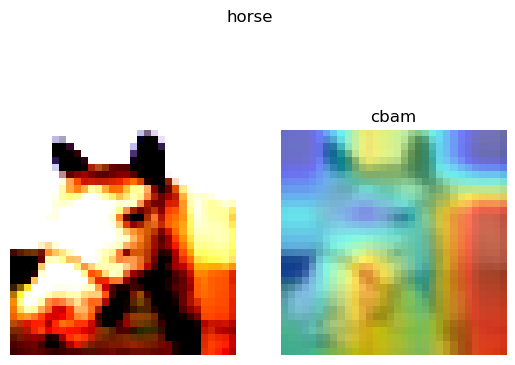

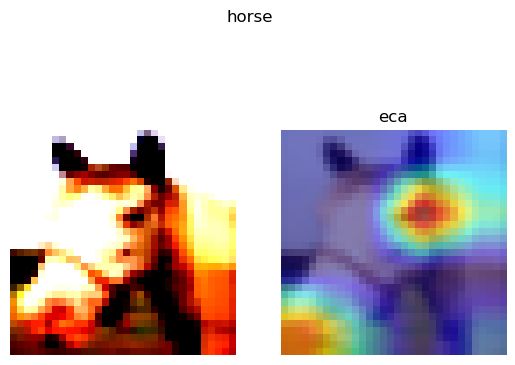

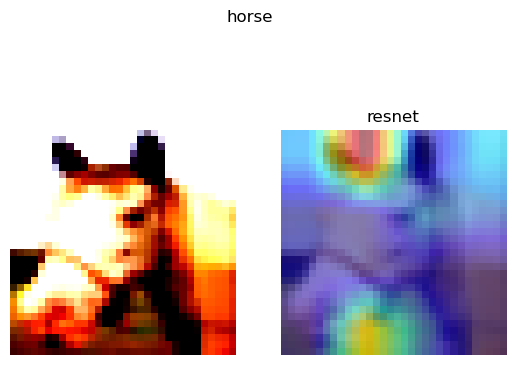

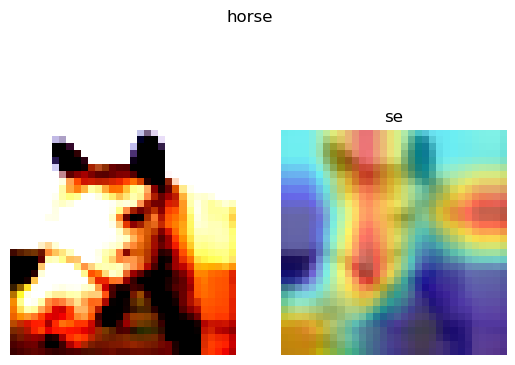

In [104]:
names = ['bam', 'cbam', 'eca', 'resnet', 'se']
models = {}

for name in names:
    with open(f'./models/{name}/{name}.pt', 'rb') as f:
        models[name] = torch.load(f)

for model in ['cbam', 'eca', 'resnet', 'se']:
    models[model].eval()
    show_activations(models[model], [models[model].layer3[-1].conv3], 42)
    plt.title(model)